In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

#plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

#preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

#modelling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, svm

#metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble

In [2]:
#import dataset, add hyperparameters
multiclass_df = pd.read_csv('/Users/agar/_METIS/exercises/Project_3/data_source/engineered_data')

new_features_df = multiclass_df

new_features_df["super_left_better"] = multiclass_df['asian_pop']*multiclass_df['asian_vote']*multiclass_df['white_bachelors']
new_features_df["super_param"] = multiclass_df['latino_adult_percent']*multiclass_df['latino_pop']*multiclass_df['other_pop']*multiclass_df['state_fips']*multiclass_df['white_bachelors']*multiclass_df['bachelors']*multiclass_df['income_median']*multiclass_df['metro1_percent_pop']*multiclass_df['other_pop']
new_features_df["super_param_2"] = new_features_df["super_param"]**2
new_features_df["super_left"] = multiclass_df['asian_pop']*multiclass_df['asian_vote']*multiclass_df['asian_adult_percent']*multiclass_df['latino_vote']*multiclass_df['white_bachelors']*multiclass_df['larg1_percent_pop']
new_features_df["super_right"] = multiclass_df['white_adult_percent']*multiclass_df['white_pop']*multiclass_df['white_vote']*multiclass_df['white_no_college']*multiclass_df['metro_none_percent_pop']*multiclass_df['metro3_percent_pop']*multiclass_df['metro2_percent_pop']*multiclass_df['native_adult_percent']*multiclass_df['native_pop']*multiclass_df['native_vote']
new_features_df["super_middle"] = multiclass_df['black_adult_percent']*multiclass_df['black_pop']*multiclass_df['black_vote']

financials_df = pd.read_csv('/Users/agar/_METIS/exercises/Project_3/financials_df.csv')

mask_years = new_features_df["year"] != 2010 
new_features_years = new_features_df[mask_years]
new_features_years['ID_DIST'] = new_features_years['year'].astype(str) + "-" + new_features_years['district_id']

finance_demo = pd.merge(new_features_years, financials_df, how='left', on=['ID_DIST'])
finance_demo = finance_demo.dropna()

prev_party_df = pd.read_csv("prev_party_id.csv")
finance_demo_prev_part = pd.merge(finance_demo, prev_party_df, how='left', left_on=['year_x', "district_id_x"], right_on=['year', "district_id"])
finance_demo_prev_part = finance_demo_prev_part.fillna(0)

In [11]:
#create test and train
mask = finance_demo_prev_part["year_x"] == 2018
holdout = finance_demo_prev_part[mask]

mask_2 = finance_demo_prev_part["year"] != 2018
train = finance_demo_prev_part[mask_2]

#test: define X feature and y target 
X_holdout = holdout.drop(['ID_DIST', 'Unnamed: 0_y', 'Cand_State',
       'Cand_Office_Dist', 'year_y', 'Unnamed: 0_x', 'year_x', 'district_id_x', 'district_id_y', 'Unnamed: 0', 'district_id', 'party_change_simple', "district_id", "party", "candidate_votes", "totalvotes", "Unnamed: 0"], axis=1)
y_holdout = holdout['party_change_simple']

#training: define X feature and y target 
y_train = train['party_change_simple'].apply(np.int64)
X_train = train.drop(['ID_DIST', 'Unnamed: 0_y', 'Cand_State',
       'Cand_Office_Dist', 'year_y', 'Unnamed: 0_x', 'year_x', 'district_id_x', 'district_id_y', 'Unnamed: 0', 'district_id', 'party_change_simple', "district_id", "party", "candidate_votes", "totalvotes", "Unnamed: 0"], axis=1)

In [58]:
from collections import Counter
print(sorted(Counter(y_train).items()))

[(0, 1498), (1, 84)]


In [59]:
#simple tr/val split on training data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=42, stratify = y_train)

#scale features
scaler = StandardScaler()
X_scaled_tr = scaler.fit_transform(X_tr)

X_scaled_val = scaler.transform(X_val)

#oversample minority class 1
X_tr_smote, y_tr_smote = SMOTE().fit_resample(X_scaled_tr, y_tr)

In [64]:
#fit models
lr=LogisticRegression(max_iter=10000)
lr.fit(X_tr_smote, y_tr_smote)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_tr_smote, y_tr_smote)

gnb = GaussianNB()
gnb.fit(X_tr_smote, y_tr_smote)

dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_tr_smote, y_tr_smote)

rfc = RandomForestClassifier() 
rfc.fit(X_tr_smote, y_tr_smote)

gbc = GradientBoostingClassifier()
gbc.fit(X_tr_smote, y_tr_smote)

svm_ = svm.SVC(probability = True)
svm_.fit(X_tr_smote, y_tr_smote)



SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Logistic Regression, dark blue
 ROC AUC score =  0.9191111111111111

Recall Score: 0.7619047619047619 
Precision Score: 0.34782608695652173 
F1 Score: 0.4776119402985074 
Accuracy Score: 0.9116161616161617 

K-Nearest Neighbor, orange
 ROC AUC score =  0.8502222222222222

Recall Score: 0.7619047619047619 
Precision Score: 0.26666666666666666 
F1 Score: 0.3950617283950617 
Accuracy Score: 0.8762626262626263 

Gaussian Naive Bayes, green
 ROC AUC score =  0.814984126984127

Recall Score: 0.8571428571428571 
Precision Score: 0.0694980694980695 
F1 Score: 0.1285714285714286 
Accuracy Score: 0.3838383838383838 

Decision Tree, red
 ROC AUC score =  0.6731428571428572

Recall Score: 0.38095238095238093 
Precision Score: 0.38095238095238093 
F1 Score: 0.38095238095238093 
Accuracy Score: 0.9343434343434344 

Random Forest Classifier, purple
 ROC AUC score =  0.9483809523809523

Recall Score: 0.23809523809523808 
Precision Score: 0.2631578947368421 
F1 Score: 0.25 
Accuracy Score: 0.9242424242

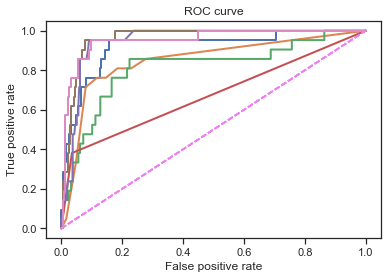

In [65]:
#metrics
def metrics(model, title):
    #metrics_dictionary = defaultdict()
    #metrics_list = []
    
    #calculate and plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_scaled_val)[:,1])
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    #plt.legend(title)
    plt.title('ROC curve'.format(title));
    
    y_pred=model.predict(X_scaled_val)
    #calculate scores
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, model.predict_proba(X_scaled_val)[:,1])
    print("{} ROC AUC score = ".format(title), roc_auc)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    print("\nRecall Score:", recall, "\nPrecision Score:", precision, "\nF1 Score:", f1, "\nAccuracy Score:", accuracy, "\n")

metrics(lr, "Logistic Regression, dark blue\n")
metrics(knn, "K-Nearest Neighbor, orange\n")
metrics(gnb, "Gaussian Naive Bayes, green\n")
metrics(dtc, "Decision Tree, red\n")
metrics(rfc, "Random Forest Classifier, purple\n")
metrics(gbc, "Gradient Boost, brown\n")
metrics(svm_, "Support Vector Machine, pink\n")
print("Logistic Regression, dark blue\n", "K-Nearest Neighbor, orange\n", "Gaussian Naive Bayes, green\n",\
      "Decision Tree, red\n", "Random Forest Classifier, purple\n", "Gradient Boost, brown\n", "Support Vector Machine, pink\n")


In [66]:
#scale features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)

In [67]:
#scale features
X_scaled_holdout = scaler.transform(X_holdout)

In [68]:
#oversample minority class 1
X_tr_smote, y_tr_smote = SMOTE().fit_resample(X_scaled_train, y_train)

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_holdoutmodel.predict_proba(X_scaled_holdout)

Logistic Regression, dark blue
 ROC AUC score =  0.8755006675567424

Recall Score: 0.8571428571428571 
Precision Score: 0.3116883116883117 
F1 Score: 0.45714285714285713 
Accuracy Score: 0.8919089759797725 

K-Nearest Neighbor, orange
 ROC AUC score =  0.9095460614152204

Recall Score: 0.9285714285714286 
Precision Score: 0.32231404958677684 
F1 Score: 0.47852760736196315 
Accuracy Score: 0.8925410872313527 

Gaussian Naive Bayes, green
 ROC AUC score =  0.6004672897196262

Recall Score: 0.8571428571428571 
Precision Score: 0.06824644549763033 
F1 Score: 0.12642669007901666 
Accuracy Score: 0.37104930467762326 

Decision Tree, red
 ROC AUC score =  0.863206497552292

Recall Score: 0.7738095238095238 
Precision Score: 0.47794117647058826 
F1 Score: 0.5909090909090909 
Accuracy Score: 0.943109987357775 

Random Forest Classifier, purple
 ROC AUC score =  0.8868491321762348

Recall Score: 0.7857142857142857 
Precision Score: 0.7857142857142857 
F1 Score: 0.7857142857142857 
Accuracy Score

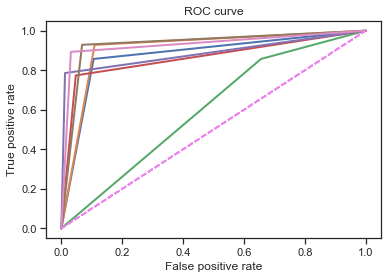

In [69]:
#metrics
def metrics(model, title):
    #metrics_dictionary = defaultdict()
    #metrics_list = []
    
    #calculate and plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_holdout, model.predict_proba(X_scaled_holdout)[:,1]> 0.5)
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    #plt.legend(title)
    plt.title('ROC curve'.format(title));
    
    y_pred=model.predict(X_scaled_holdout)
    #calculate scores
    recall = recall_score(y_holdout, y_pred)
    precision = precision_score(y_holdout, y_pred)
    roc_auc = roc_auc_score(y_holdout, model.predict_proba(X_scaled_holdout)[:,1]> 0.5)
    print("{} ROC AUC score = ".format(title), roc_auc)
    f1 = f1_score(y_holdout, y_pred)
    accuracy = accuracy_score(y_holdout, y_pred)
    print("\nRecall Score:", recall, "\nPrecision Score:", precision, "\nF1 Score:", f1, "\nAccuracy Score:", accuracy, "\n")

metrics(lr, "Logistic Regression, dark blue\n")
metrics(knn, "K-Nearest Neighbor, orange\n")
metrics(gnb, "Gaussian Naive Bayes, green\n")
metrics(dtc, "Decision Tree, red\n")
metrics(rfc, "Random Forest Classifier, purple\n")
metrics(gbc, "Gradient Boost, brown\n")
metrics(svm_, "Support Vector Machine, pink\n")
print("Logistic Regression, dark blue\n", "K-Nearest Neighbor, orange\n", "Gaussian Naive Bayes, green\n",\
      "Decision Tree, red\n", "Random Forest Classifier, purple\n", "Gradient Boost, brown\n", "Support Vector Machine, pink\n")


In [75]:
rank = rfc.feature_importances_
columns = X_train.columns
concated = pd.concat([pd.Series(rank), pd.Series(columns)], axis=1)

In [87]:
concated.head()

,0,1
0,0.071785,sum_flips_total
1,0.019020,state_fips
2,0.015965,metro1_percent_pop
3,0.005996,metro2_percent_pop
4,0.006832,metro3_percent_pop


In [91]:
concated.sort_values(0, ascending=False)

,0,1
49,0.119559,Operating_Expenditure
46,0.078044,Party_Committee_Contribution
0,0.071785,sum_flips_total
43,0.065485,Individual_Unitemized_Contribution
33,0.061808,flips_sq
41,0.055960,Total_Disbursement
48,0.043805,Total_Contribution
40,0.040356,Total_Receipt
42,0.033715,Individual_Itemized_Contribution
44,0.030931,Individual_Contribution


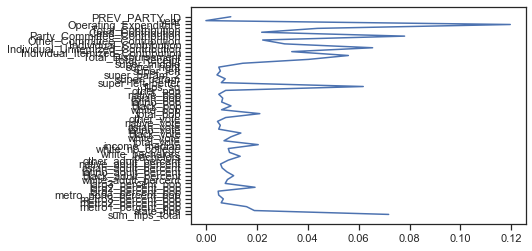

In [90]:
plt.plot(concated[0], concated[1])


# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)

Feature ranking:
1. feature 49 (0.119559)
2. feature 46 (0.078044)
3. feature 0 (0.071785)
4. feature 43 (0.065485)
5. feature 33 (0.061808)
6. feature 41 (0.055960)
7. feature 48 (0.043805)
8. feature 40 (0.040356)
9. feature 42 (0.033715)
10. feature 44 (0.030931)
11. feature 45 (0.022292)
12. feature 47 (0.021903)
13. feature 26 (0.021175)
14. feature 18 (0.020551)
15. feature 7 (0.019296)
16. feature 1 (0.019020)
17. feature 2 (

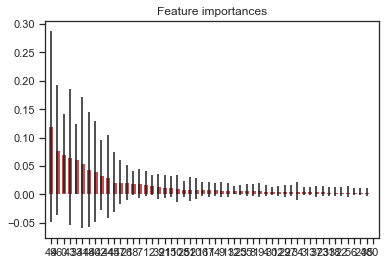

In [74]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
"""
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
"""
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [56]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_scaled_val)[:, 1] >= threshold)
    flip_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(flip_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no flip', 'flip'],
           yticklabels=['no flip', 'flip']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

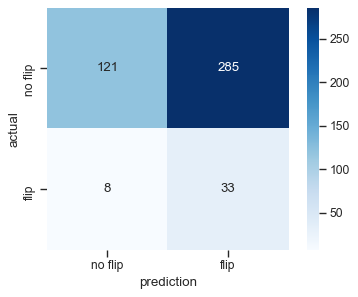

In [57]:
make_confusion_matrix(gnb, threshold=0.5)

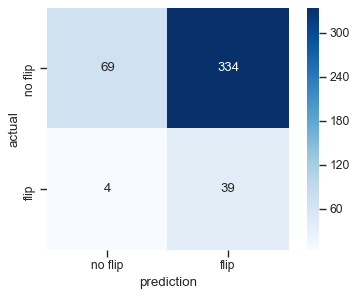

In [36]:
make_confusion_matrix(gnb, threshold=0.06)

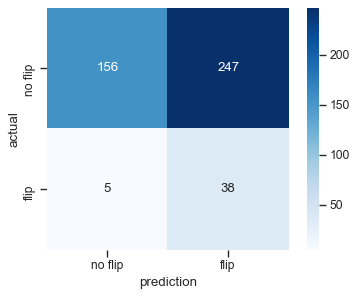

In [39]:
make_confusion_matrix(gnb, threshold=0.8)

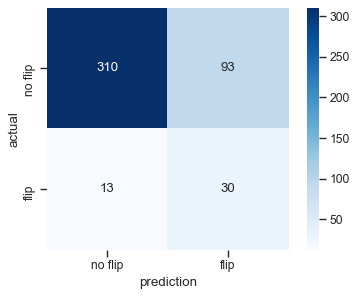

In [37]:
make_confusion_matrix(knn, threshold=0.5)

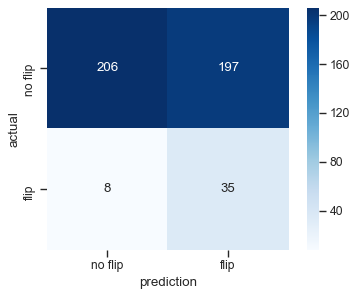

In [38]:
make_confusion_matrix(knn, threshold=0.06)

In [97]:
y_new  = lr.predict_proba(X_scaled_holdout)

In [101]:
y_pred_dataset = pd.DataFrame({'predict_flip': y_new[:, 0], 'predict_stay': y_new[:, 1]})


In [104]:
prediction_2018 = pd.merge(holdout, y_pred_dataset, how='left', left_index=True, right_index=True)

In [106]:
prediction_2018.to_csv("predicition_2018.csv")